In [1]:
import numpy as np

import matplotlib.pyplot as plt

from photutils.datasets import apply_poisson_noise
from astropy.modeling import models
from astropy.wcs import WCS
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.nddata import StdDevUncertainty
import astropy.units as u

from specutils import Spectrum1D
from specutils.fitting import find_lines_threshold, fit_generic_continuum

from specreduce.calibration_data import load_pypeit_calibration_lines
from specreduce.utils.synth_data import make_2d_arc_image, make_2d_spec_image
from specreduce.tracing import FlatTrace
from specreduce.extract import BoxcarExtract

In [2]:
%load_ext autoreload
%autoreload 2

np.random.seed(8675309)

In [3]:
nx = 3000
ny = 1000
const = 5
noise = 5
width = 5
center = ny / 2
x = np.arange(nx)
y = np.arange(ny)
xx, yy = np.meshgrid(x, y)
profile = models.Moffat1D()
wave_unit = u.Angstrom 
extent = [3500, 7000]

In [4]:
wcs = WCS(naxis=2)
wcs.wcs.ctype[0] = 'WAVE'
wcs.wcs.ctype[1] = 'PIXEL'
wcs.wcs.cunit[0] = wave_unit
wcs.wcs.cunit[1] = u.pixel
wcs.wcs.crval[0] = extent[0]
wcs.wcs.cdelt[0] = (extent[1] - extent[0]) / nx
wcs.wcs.crval[1] = 0
wcs.wcs.cdelt[1] = 1
wcs.spectral

WCS Keywords

Number of WCS axes: 1
CTYPE : 'WAVE'  
CRVAL : 3.5000000000000004e-07  
CRPIX : 0.0  
PC1_1  : 1.0  
CDELT : 1.1666666666666668e-10  
NAXIS : 0  0

In [5]:
ll = load_pypeit_calibration_lines(['HeI', 'NeI'])
ll

ion,wave,NIST,Instr,amplitude,Source
,Angstrom,,,,
str3,float64,int64,int64,int64,str25
HeI,3889.75,1,4,2565,kastb_600_PYPIT.json
HeI,4027.3292,1,4,153,kastb_600_PYPIT.json
HeI,4472.735,1,0,30,ALFOSC
HeI,4714.4644,1,4,275,kastb_600_PYPIT.json
HeI,4923.3053,1,4,656,kastb_600_PYPIT.json
HeI,5017.0772,1,4,2341,kastb_600_PYPIT.json
HeI,5877.249,1,0,1000,FORS2
HeI,6679.995,1,0,300,ALFOSC


In [6]:
#wcs.spectral.world_to_pixel(ll['wave'].value * ll['wave'].unit)
wcs.spectral.world_to_pixel(ll['wave'])

array([ 333.07142857,  450.99645714,  832.77285714, 1039.96948571,
       1218.97597143, 1299.35188571, 2036.642     , 2724.71      ,
       3056.54685714, 1318.27657143, 1578.35377143, 1768.40942857,
       1848.91031429, 1569.50882857, 1629.3398    , 2016.80865714,
       2042.0216    , 2095.98371429, 2122.30528571, 2168.99994286,
       2207.01654286, 2225.72908571, 2253.41085714, 2265.93962857,
       2283.54234286, 2329.57254286, 2371.76728571, 2404.59962857,
       2430.01065714, 2471.648     , 2488.15828571, 2577.56471429,
       2600.16045714, 2656.80748571, 2724.81757143, 2758.05491429,
       2940.18174286, 3028.44457143, 3149.78462857, 3210.85408571,
       3376.95448571, 3419.80014286, 3460.01325714, 3928.7258    ,
       4181.7794    , 4282.73702857, 4412.78548571, 4419.07991429,
       4888.38637143, 5173.38225714, 4995.34254286, 5080.11328571,
       5109.11942857, 5132.67277143, 6552.77557143])

In [7]:
profile.amplitude = 10
profile.alpha = 0.1
trace_mod = models.Chebyshev1D(degree=3, c0=0, c1=50, c2=100)
trace = yy - center + trace_mod(xx/nx)
z = const + profile(trace)
noisy = apply_poisson_noise(z)

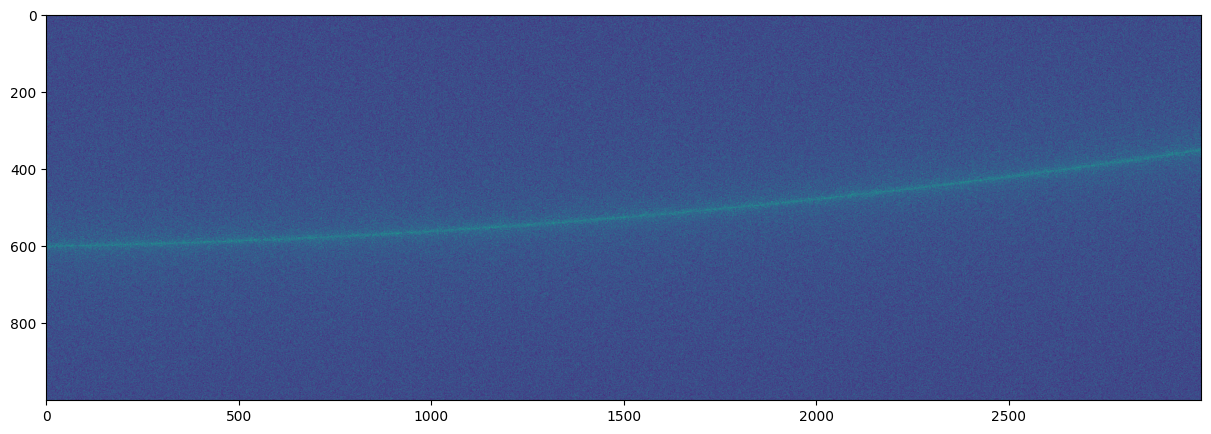

In [8]:
fig = plt.figure(figsize=(15, 5))
plt.imshow(noisy)
plt.show()

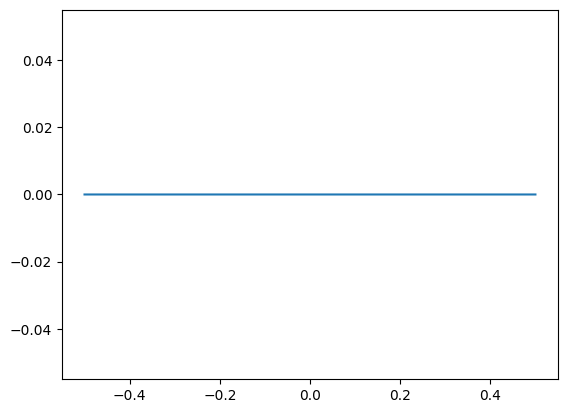

In [12]:
model2 = models.Legendre1D(degree=2, c0=-50, c1=0, c2=100)
model1 = models.Legendre1D(degree=1, c0=0, c1=100)
model = models.Chebyshev1D(degree=2, c0=50, c1=0, c2=100)
model3 = models.Legendre1D(degree=0)
x = (np.arange(3000)-1500)/3000
y = model3(x)
plt.plot(x, y)

In [10]:
xx + model((yy/2 - yy)/ny)

array([[-5.00000000e+01, -4.90000000e+01, -4.80000000e+01, ...,
         2.94700000e+03,  2.94800000e+03,  2.94900000e+03],
       [-4.99999500e+01, -4.89999500e+01, -4.79999500e+01, ...,
         2.94700005e+03,  2.94800005e+03,  2.94900005e+03],
       [-4.99998000e+01, -4.89998000e+01, -4.79998000e+01, ...,
         2.94700020e+03,  2.94800020e+03,  2.94900020e+03],
       ...,
       [-2.99550000e-01,  7.00450000e-01,  1.70045000e+00, ...,
         2.99670045e+03,  2.99770045e+03,  2.99870045e+03],
       [-1.99800000e-01,  8.00200000e-01,  1.80020000e+00, ...,
         2.99680020e+03,  2.99780020e+03,  2.99880020e+03],
       [-9.99500000e-02,  9.00050000e-01,  1.90005000e+00, ...,
         2.99690005e+03,  2.99790005e+03,  2.99890005e+03]])

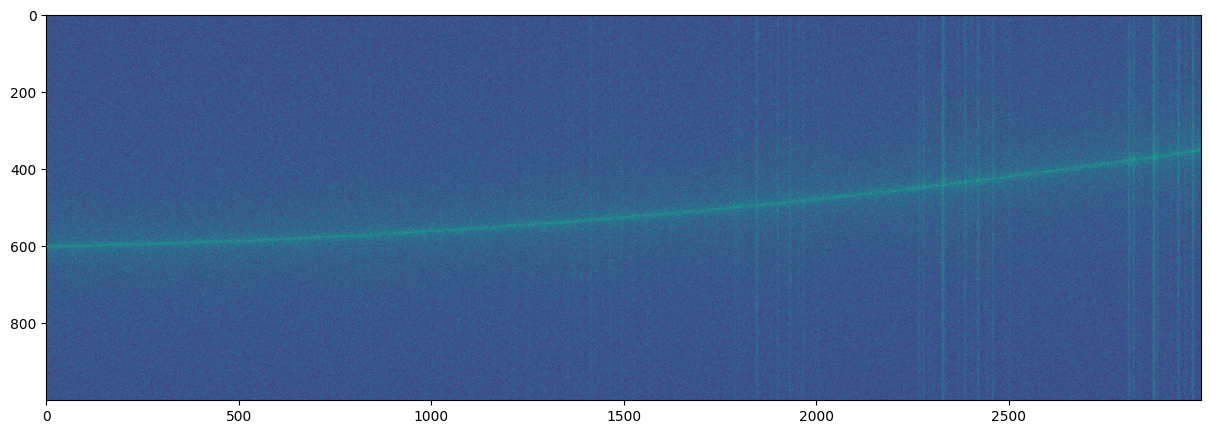

In [11]:
im = make_2d_spec_image()
fig = plt.figure(figsize=(15, 5))
plt.imshow(im)

In [12]:
im = make_2d_arc_image(linelists=['HeI', 'ArI', 'ArII'], line_fwhm=3, tilt_func=model2)

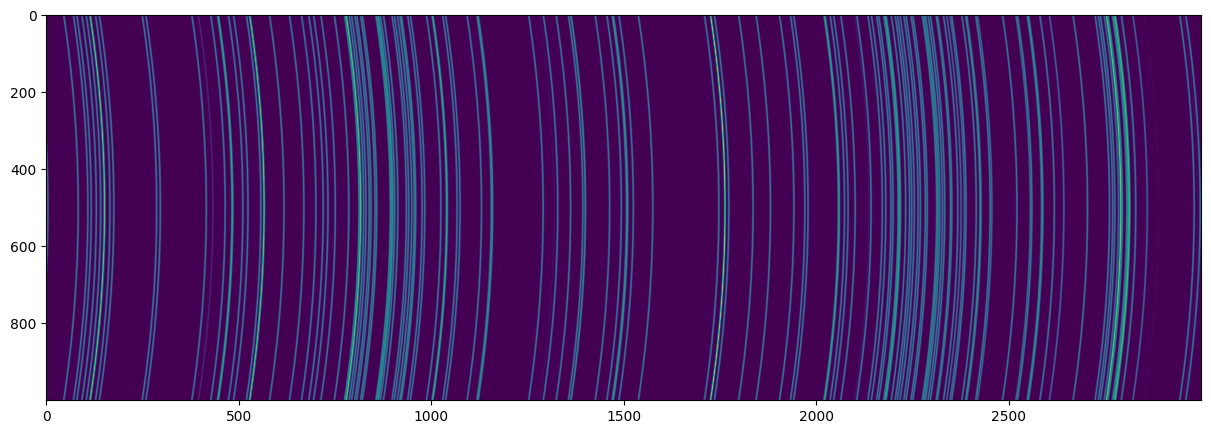

In [13]:
fig = plt.figure(figsize=(15, 5))
#ax = plt.subplot(projection=wcs)
#wave, pix = ax.coords
#wave.set_format_unit(u.um)
plt.imshow(im)

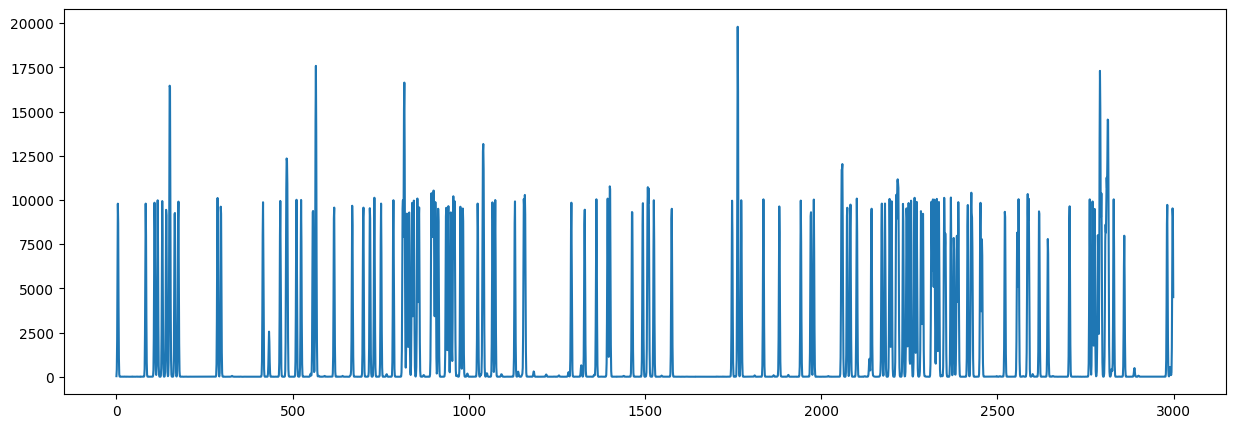

In [14]:
fig = plt.figure(figsize=(15, 5))
plt.plot(im.data[500, :])
plt.show()

In [15]:
non_linear_header = {
    'CTYPE1': 'AWAV-GRA',  # Grating dispersion function with air wavelengths
    'CUNIT1': 'Angstrom',  # Dispersion units
    'CRPIX1': 519.8,       # Reference pixel [pix]
    'CRVAL1': 7245.2,      # Reference value [Angstrom]
    'CDELT1': 2.956,       # Linear dispersion [Angstrom/pix]
    'PV1_0': 4.5e5,        # Grating density [1/m]
    'PV1_1': 1,            # Diffraction order
    'PV1_2': 27.0,         # Incident angle [deg]
    'PV1_3': 1.765,        # Reference refraction
    'PV1_4': -1.077e6,     # Refraction derivative [1/m]
    'CTYPE2': 'PIXEL',     # Spatial detector coordinates
    'CUNIT2': 'pix',       # Spatial units
    'CRPIX2': 1,           # Reference pixel
    'CRVAL2': 0,           # Reference value
    'CDELT2': 1            # Spatial units per pixel
}

linear_header = {
    'CTYPE1': 'AWAV',  # Grating dispersion function with air wavelengths
    'CUNIT1': 'Angstrom',  # Dispersion units
    'CRPIX1': 519.8,       # Reference pixel [pix]
    'CRVAL1': 7245.2,      # Reference value [Angstrom]
    'CDELT1': 2.956,       # Linear dispersion [Angstrom/pix]
    'CTYPE2': 'PIXEL',     # Spatial detector coordinates
    'CUNIT2': 'pix',       # Spatial units
    'CRPIX2': 1,           # Reference pixel
    'CRVAL2': 0,           # Reference value
    'CDELT2': 1            # Spatial units per pixel
}

non_linear_wcs = WCS(header=non_linear_header)
linear_wcs = WCS(header=linear_header)

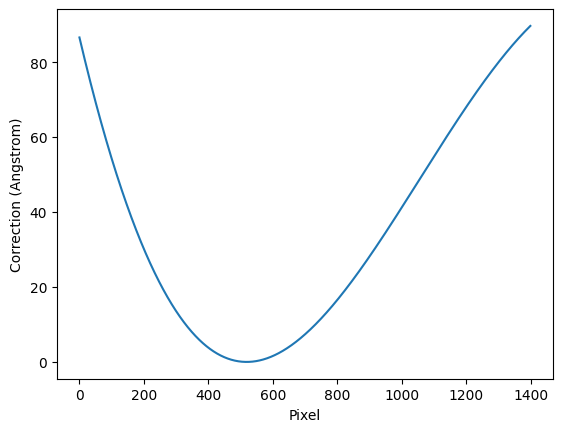

In [16]:
# this re-creates Paper III, Figure 5
pix_array = np.arange(1400)
nlin = non_linear_wcs.spectral.pixel_to_world(pix_array)
lin = linear_wcs.spectral.pixel_to_world(pix_array)
resid = (nlin - lin).to(u.Angstrom)
plt.plot(pix_array, resid)
plt.xlabel("Pixel")
plt.ylabel("Correction (Angstrom)")
plt.show()

In [17]:
linear_wcs.spectral.pixel_to_world(pix_array)

<SpectralCoord [5.7116272e-07, 5.7145832e-07, 5.7175392e-07, ..., 9.8411592e-07,
   9.8441152e-07, 9.8470712e-07] m>

In [18]:
linear_wcs.spectral

WCS Keywords

Number of WCS axes: 1
CTYPE : 'AWAV'  
CRVAL : 7.2452e-07  
CRPIX : 519.8  
PC1_1  : 1.0  
CDELT : 2.956e-10  
NAXIS : 0  0

In [19]:
tmod = models.Legendre1D(degree=2, c0=50, c1=0, c2=100)
match_im = make_2d_arc_image(nx=1400, ny=1024, linelists=['HeI', 'NeI'], wcs=linear_wcs, line_fwhm=3, tilt_func=tmod, amplitude_scale=5e-4)
arclist = load_pypeit_calibration_lines(['HeI', 'NeI'])['wave']
arclist_pix = linear_wcs.spectral.world_to_pixel(arclist)
arclist_pix = arclist_pix[(arclist_pix > 0) & (arclist_pix < 1400)]

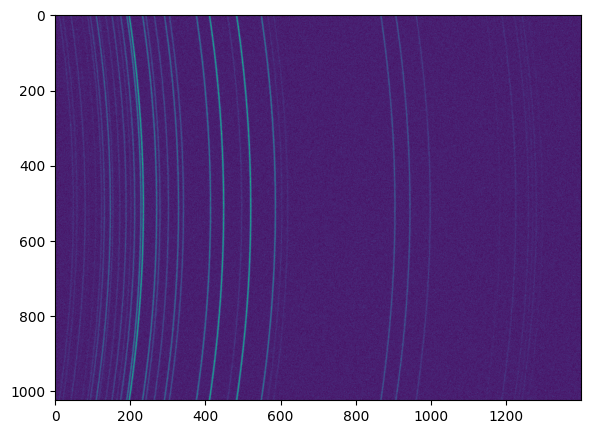

In [20]:
fig = plt.figure(figsize=(15, 5))
plt.imshow(match_im)

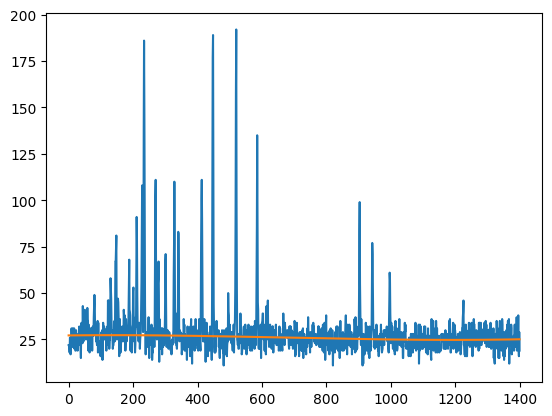

In [21]:
trace = FlatTrace(match_im, 512)
arc_sp = BoxcarExtract(match_im, trace, width=5).spectrum
arc_sp.uncertainty = StdDevUncertainty(np.sqrt(arc_sp.flux).value)
continuum = fit_generic_continuum(arc_sp, median_window=51)
fig = plt.figure()
plt.plot(arc_sp.spectral_axis, arc_sp.flux)
plt.plot(arc_sp.spectral_axis, continuum(arc_sp.spectral_axis))
#plt.vlines(arclist_pix, 0, arc_sp.flux.max().value, color='r')
plt.show()

In [32]:
arc_sub = Spectrum1D(spectral_axis=arc_sp.spectral_axis, flux=arc_sp.flux - continuum(arc_sp.spectral_axis))
arc_sub.uncertainty = arc_sp.uncertainty
detlines = find_lines_threshold(arc_sub, noise_factor=5)
detlines


If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


line_center,line_type,line_center_index
pix,,
float64,str8,int64
148.0,emission,148
211.0,emission,211
228.0,emission,228
234.0,emission,234
270.0,emission,270
301.0,emission,301
328.0,emission,328
340.0,emission,340
